In [ ]:
# ResNet(Skip connection, Regidual Block) 잔차를 레이어에 더해준다
        ## 핵심 아이디어 : 잔차 학습(Residual Learning)
        # 층을 지나가면서 점차 0에 가까워지기 떄문에 기울기 소실 문제가 생기는데
        # 입력~출력층을 지나는 것과/ 입력층 가지고 있는 스킵커넥션 이 두 개의 값을 더해준다.

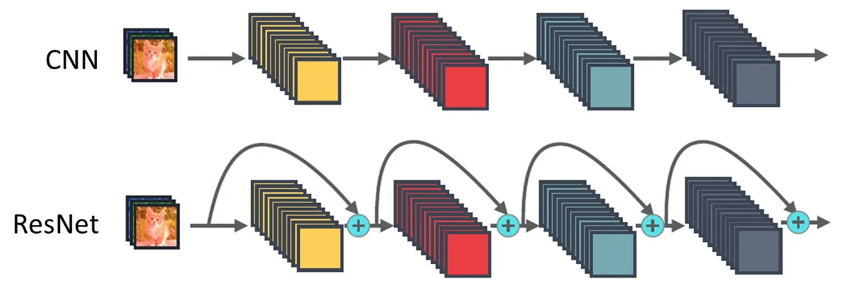

### ResNet 구조
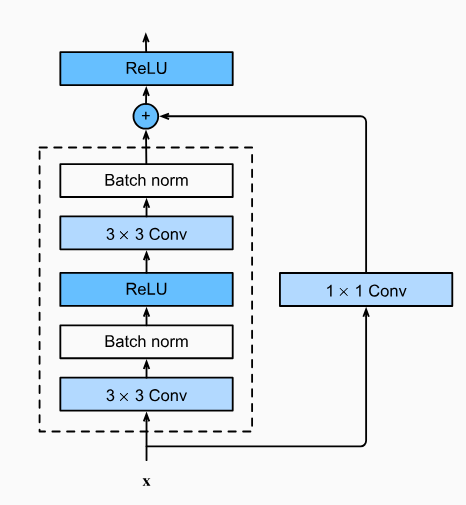

In [ ]:
import torch.nn as nn
import torch
# 1. 라이브러리 및 계층 정의
conv1 = nn.Conv2d(3,32,kernel_size = 3, padding=1)      # 3개의 채널을 받아 32개의 특징맵 출력
batch1 = nn.BatchNorm2d(32) # BatchNorm2d 배치 정규화
relu = nn.ReLU()       # 활성화 함수
conv2 = nn.Conv2d(32,64,kernel_size = 3, padding=1)     # 첫번째 합성곱층의 32채널을 받아 64개의 특징맵을 출력
batch2 = nn.BatchNorm2d(64) # 64개 채널에 대한 배치 정규화
# 2. 입력 데이터 생성 및 저장
x = torch.randn(2,3,32,32)      #  (배치 크기, 채널 수, 높이, 너비) 이미지 2개, 3채널(RGB), 32X32크기
x_ = x      # 스킵커넥션을 위해서 초기 입력을 저장
# 3. 순차적 연산 # 계속 x의 값을 받아 계산되어야 하기 때문에 x의 변수로 게속 받는 것
x = conv1(x)   # (2,3,32,32)-> (2,32,32,32) 
x = batch1(x)   # (2,32,32,32) -> (2,32,32,32) 
x = relu(x)     # (2,32,32,32) -> (2,32,32,32) 
x = conv2(x)    # (2,32,32,32) -> (2,64,32,32) 
x = batch2(x)   # (2,64,32,32) -> (2,64,32,32) 
x.size(),x_.size()

(torch.Size([2, 64, 32, 32]), torch.Size([2, 3, 32, 32]))

In [ ]:
downsample = nn.Conv2d(3,64,kernel_size=1) # x의 마지막 출력 형태와 같아야 나중에 합산 가능하기 때문에 다운샘플링해준다. 입력축일수록 채널의 수가 많기 떄문에
down_x = downsample(x_)                    # 폴링층을 거치면서 채널의 수가 작아짐. x_가 입력층의 원본을 가지고 있으면 채널수가 많기 때문에 (입력~출력을 진행한 x에 비해)그걸 다운샘플링 해줘야한다
down_x.size()

torch.Size([2, 64, 32, 32])

In [ ]:
# basicblock 생성
import torch.nn as nn
import torch
class BasicBlock(nn.Module):
    def __init__(self,in_channel, out_channel,hidden_dim):
        super(BasicBlock,self).__init__()
        self.conv1 = nn.Conv2d(in_channel, hidden_dim,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(hidden_dim,out_channel, kernel_size=3,padding=1)
        self.batch1 = nn.BatchNorm2d(hidden_dim)
        self.batch2 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.downsample = nn.Conv2d(in_channel, out_channel,kernel_size=1)
    def forward(self,x):
        x_ = x      # 스킵 커넥션을 위해 원본 입력을 보존/ x의 값을 카피/ 다시 돌면서 변화한 x의 값을 다시 카피해서 원본을 가지고 있는다
        x_ = self.downsample(x_)
        x = self.relu(self.batch1(self.conv1(x)))   # -conv1--> BN --> ReLU 진행
        x = self.batch2(self.conv2(x))  # conv2 --> BN 진행
        x += x_                     # x_의 초기값과 x의 값을 합산해준다
        out = self.relu(x)
        return out


In [21]:
class ResNet(nn.Module):
    def __init__(self, class_num = 10):
        super(ResNet,self).__init__()
        self.b1 = BasicBlock(3,64,32) 
        self.b2 = BasicBlock(64,256,128)
        self.b3 = BasicBlock(256,256,256)

        self.pool = nn.AvgPool2d(2)

        self.fc1 = nn.Linear(256*4*4 , 2048) # (5x4096 and 262144x2048)
        self.fc2 = nn.Linear(2048 , 512)
        self.fc3 = nn.Linear(512 , class_num)

        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.pool(self.b1(x))     # (64,32,32) -> (64,16,16)
        x = self.pool(self.b2(x))     # (256,8,8)
        x = self.pool(self.b3(x))     # (256,4,4)
        x = torch.flatten(x, start_dim=1)     
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)

        return out

In [22]:
# 데이터는 인간 - 말
# 학습 - 평가

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_dataset =  datasets.ImageFolder(root = './data/horse-or-human/train', transform=transform)
test_dataset =  datasets.ImageFolder(root = './data/horse-or-human/test', transform=transform)
train_loader = DataLoader(train_dataset,batch_size=5,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=5,shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet(2)
model.to(device)

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
epochs = 20
# 학습루프
for epoch in range(epochs):
    tqdm_obj = tqdm(train_loader,desc=f'epoch : {epoch+1}/{epochs}')
    for data, label in tqdm_obj:
        optim.zero_grad()
        preds = model(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()

        tqdm_obj.set_postfix(loss=loss.item())
        

torch.save(model.state_dict(), 'resnet.pth')    

epoch : 20/20: 100%|██████████| 206/206 [01:21<00:00,  2.53it/s, loss=2.03e-5] 


In [23]:
# 평가
model.load_state_dict(torch.load('resnet.pth',map_location=device,weights_only=True))
# 예측
# 평가 루프
# test_loader가 이미 정의되어 있다고 가정
model.eval()  # 평가 모드로 전환 (dropout, batchnorm 등 비활성화)
total_loss = 0.0
total_correct = 0
total_samples = 0

criterion = nn.CrossEntropyLoss()
with torch.no_grad():  # 그래디언트 계산 비활성화
    for data, label in tqdm(test_loader, desc="Evaluating"):
        data, label = data.to(device), label.to(device)
        preds = model(data)
        loss = criterion(preds, label)
        total_loss += loss.item() * data.size(0)  # 배치 손실 합산
        total_correct += (preds.argmax(dim=1) == label).sum().item()
        total_samples += data.size(0)

avg_loss = total_loss / total_samples
accuracy = total_correct / total_samples

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

Evaluating: 100%|██████████| 52/52 [00:06<00:00,  7.59it/s]

Test Loss: 0.5068, Test Accuracy: 0.9414


### dropout으로 성능 높이기

In [26]:
# dropout해서 성능을 더 높힌다
 
#from torchvision.models.resnet import ResNet50
#ResNet50

class ResNet(nn.Module):
    def __init__(self, class_num = 10):
        super(ResNet,self).__init__()
        self.b1 = BasicBlock(3,64,32) 
        self.b2 = BasicBlock(64,256,128)
        self.b3 = BasicBlock(256,256,256)

        self.pool = nn.AvgPool2d(2)

        self.fc1 = nn.Linear(256*4*4 , 2048) 
        self.fc2 = nn.Linear(2048 , 512)
        self.fc3 = nn.Linear(512 , class_num)

        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
    def forward(self,x):
        x = self.dropout1(self.pool(self.b1(x)))
        x = self.dropout1(self.pool(self.b2(x)))  
        x = self.dropout2(self.pool(self.b3(x))) 
        x = torch.flatten(x, start_dim=1)             
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)

        return out

In [28]:
# 평가
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_dataset =  datasets.ImageFolder(root = './data/horse-or-human/train', transform=transform)
test_dataset =  datasets.ImageFolder(root = './data/horse-or-human/test', transform=transform)
train_loader = DataLoader(train_dataset,batch_size=5,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=5,shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet(2)
model.to(device)

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
epochs = 20
# 학습루프
for epoch in range(epochs):
    tqdm_obj = tqdm(train_loader,desc=f'epoch : {epoch+1}/{epochs}')
    for data, label in tqdm_obj:
        optim.zero_grad()
        preds = model(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()

        tqdm_obj.set_postfix(loss=loss.item())
        

torch.save(model.state_dict(), 'resnet.pth')   

epoch : 20/20: 100%|██████████| 206/206 [01:17<00:00,  2.65it/s, loss=6.68e-6] 


In [ ]:
# train 평가
model.eval()  # 평가 모드로 전환 (dropout, batchnorm 등 비활성화)
total_loss = 0.0
total_correct = 0
total_samples = 0

criterion = nn.CrossEntropyLoss()
with torch.no_grad():  # 그래디언트 계산 비활성화
    for data, label in tqdm(train_loader, desc="Evaluating"):
        data, label = data.to(device), label.to(device)
        preds = model(data)
        loss = criterion(preds, label)
        total_loss += loss.item() * data.size(0)  # 배치 손실 합산
        total_correct += (preds.argmax(dim=1) == label).sum().item()
        total_samples += data.size(0)

avg_loss = total_loss / total_samples
accuracy = total_correct / total_samples

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

Evaluating: 100%|██████████| 206/206 [00:23<00:00,  8.83it/s]

Test Loss: 0.0000, Test Accuracy: 1.0000


In [ ]:
# test 평가
model.load_state_dict(torch.load('resnet.pth',map_location=device,weights_only=True))
# 예측
# 평가 루프
model.eval()  # 평가 모드로 전환 (dropout, batchnorm 등 비활성화)
total_loss = 0.0
total_correct = 0
total_samples = 0

criterion = nn.CrossEntropyLoss()
with torch.no_grad():  # 그래디언트 계산 비활성화
    for data, label in tqdm(test_loader, desc="Evaluating"):
        data, label = data.to(device), label.to(device)
        preds = model(data)
        loss = criterion(preds, label)
        total_loss += loss.item() * data.size(0)  # 배치 손실 합산
        total_correct += (preds.argmax(dim=1) == label).sum().item()
        total_samples += data.size(0)

avg_loss = total_loss / total_samples
accuracy = total_correct / total_samples

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

Evaluating: 100%|██████████| 52/52 [00:04<00:00, 11.18it/s]

Test Loss: 1.0336, Test Accuracy: 0.8906
